In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import random
import os

params = {'figure.titlesize': 20,
          'axes.grid': True,
          'axes.labelsize': 10,
          'axes.titlesize': 12,
          'axes.linewidth': 1.5,
          'xtick.minor.visible': True,
          'xtick.major.width': 1.5,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'xtick.major.size': 7,
          'xtick.minor.size': 5,
          'xtick.labelsize': 10,
          'ytick.minor.visible': True,
          'ytick.major.width': 1.5,
          'ytick.major.size': 7,
          'ytick.minor.size': 5,
          'ytick.labelsize': 10,
          'legend.fontsize': 10,
          'legend.labelspacing': 0.3,
          'font.family': 'sans-serif'}

plt.rcParams.update(params)

# Error structures

In [3]:
path = os.getcwd()

def get_error(VR, SS, ANX, INT, scale, alpha, error_type):
    "Return the error structure specified by error_type. error_type can be 'simple', 'AR1' or 'compound'.\
     If simple error then set alpha = 0, if AR1 or compound error then set scale = 0."
    
    var_vr = np.nanvar(VR)  
    var_ss = np.nanvar(SS)
    var_anx = np.nanvar(ANX)
    var_int = np.nanvar(INT)
    std_vr, std_ss, std_anx, std_int = np.sqrt(var_vr), np.sqrt(var_ss), np.sqrt(var_anx), np.sqrt(var_int)
    
    #simple 
    simple_error = scale*np.random.randn(4)*np.array([var_vr, var_ss, var_anx, var_int])
    
    #AR1
    AR1_cov = np.zeros((4,4))
    AR1_cov[0, 0], AR1_cov[1, 1], AR1_cov[2, 2], AR1_cov[3, 3] = var_vr, var_ss, var_anx, var_int #diagonal 0
    AR1_cov[0, 1], AR1_cov[1, 2], AR1_cov[2, 3] = alpha*np.array([std_vr*std_ss, std_ss*std_anx, std_anx*std_int]) #diagonal 1
    AR1_cov[1, 0], AR1_cov[2, 1], AR1_cov[3, 2] = AR1_cov[0, 1], AR1_cov[1, 2], AR1_cov[2, 3]
    AR1_cov[0, 2], AR1_cov[1, 3] = alpha**2*np.array([std_vr*std_anx, std_ss*std_int]) #diagonal 2
    AR1_cov[2, 0], AR1_cov[3, 1] = AR1_cov[0, 2], AR1_cov[1, 3]
    AR1_cov[0, 3] = AR1_cov[3, 0] = alpha**3*(std_vr*std_int) #diagonal 3
    
    #compound 
    cov = np.zeros((4,4))
    cov[0, 0], cov[1, 1], cov[2, 2], cov[3, 3] = var_vr, var_ss, var_anx, var_int #diagonal 0
    cov[0, 1], cov[1, 2], cov[2, 3] = alpha*np.array([std_vr*std_ss, std_ss*std_anx, std_anx*std_int]) #diagonal 1
    cov[1, 0], cov[2, 1], cov[3, 2] = cov[0, 1], cov[1, 2], cov[2, 3]
    cov[0, 2], cov[1, 3] = alpha*np.array([std_vr*std_anx, std_ss*std_int]) #diagonal 2
    cov[2, 0], cov[3, 1] = cov[0, 2], cov[1, 3]
    cov[0, 3] = cov[3, 0] = alpha*(std_vr*std_int) #diagonal 3
    
    if error_type == 'simple': 
        return simple_error
    elif error_type == 'AR1':
        return AR1_cov 
    else: 
        return cov

In [4]:
def get_matrix(ind, contemp_coeff, lagged_coeff, scale, alpha, error_type):
    "Return simulated data of VR, SS, ANX and INT in 75x4 matrix for individual ind with error structure\
     specified by error_type."
    
    dir="GIMME analyses/Cleaned GIMME Data/" 
    VR, SS, ANX, INT = np.genfromtxt(dir+'Control_Group/10'+ind+'.txt', skip_header=1, unpack=True)
    var_vr, mean_vr = np.nanvar(VR), np.nanmean(VR)  
    var_ss, mean_ss = np.nanvar(SS), np.nanmean(SS)
    var_anx, mean_anx = np.nanvar(ANX), np.nanmean(ANX)
    var_int, mean_int = np.nanvar(INT), np.nanmean(INT)
    
    length = 75
    M = np.zeros((length,4))
    t = np.arange(0,length) 
    C = get_error(VR, SS, ANX, INT, scale, alpha, error_type)
    M[0,:] = np.array([mean_vr, mean_ss, mean_anx, mean_int]) + C

    #M[r] = (I-A)^-1 * B * M[r-1] + noise + mean 
    for r in range(1,length):   
        M[r] = np.matmul(np.matmul(np.linalg.inv(np.eye(4)-contemp_coeff),lagged_coeff),M[r-1])     
        M[r] += C
    M[:,:] += np.array([mean_vr, mean_ss, mean_anx, mean_int])

    return M

# Covaraince matrices heatmaps

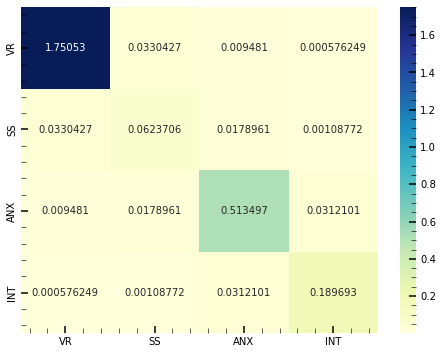

In [5]:
#example 

dir="GIMME analyses/Cleaned GIMME Data/" 
VR, SS, ANX, INT = np.genfromtxt(dir+'Control_Group/1001.txt', skip_header=1, unpack=True)
AR1_cov = get_error(VR, SS, ANX, INT, 0, 0.1, 'AR1')

import seaborn as sns

labels = ['VR', 'SS', 'ANX', 'INT']

plt.figure(figsize=(8,6))
sns.heatmap(AR1_cov, annot=True, fmt='g', xticklabels=labels, yticklabels=labels, cmap='YlGnBu')
plt.show()

# Scaled noise and changed matrix

The code below generates 10 sets of simulated data with each set containing simulated data of VR, SS, ANX, INT for 13 individuals. If <code>change_matrix_coeff = True</code> then the SS and VR coefficients are exchanged in individual 1's coefficient matrix only and data is generated with scale 1 simple noise. If <code>change_matrix_coeff = False</code> then all coefficient matrices remain unchanged however data is generated with scaled simple noise (e.g scale 2, 10 or 100).  

In [ ]:
numbers = ['01','02','03','04','05','06','07','08','09','10','11','12','13']
length = 75
change_matrix_coeff = True
dir = path + '/GIMME analyses/Cleaned GIMME Data/'

for rep in range(1,11): #10 sets 
    for num in numbers:
        data = np.loadtxt(dir+'Control_group_output/individual/10'+num+'Betas.csv', skiprows=1, usecols=range(1,9), delimiter=',')
        A = data[:,4:] #contemp coeff, (4x4)
        B = data[:,:4] #lagged coeff
        
        if change_matrix_coeff:
            scale = 1
            if num == '01':
                A_changed = np.copy(A)
                A_changed[1, 0] = A_changed[0, 1] #switch SS --> VR to VR --> SS
                A_changed[0, 1] = 0
            
                M = get_matrix(num, A_changed, B, scale, 0, 'simple')

                np.savetxt(path+'/Change_matrix_coeff/rep_'+str(rep)+'/ind_'+str(int(num))+'.txt', 
                           M, delimiter=',', header='VR,SS,ANX,INT', comments='')
                
            M = get_matrix(num, A, B, scale, 0, 'simple')
            np.savetxt(path+'/Change_matrix_coeff/rep_'+str(rep)+'/ind_'+str(int(num))+'.txt', 
                       M, delimiter=',', header='VR,SS,ANX,INT', comments='')
        else:
            scale = 2
            M = get_matrix(num, A, B, scale, 0, 'simple')
            np.savetxt(path+'/Scale_'+str(scale)+'_noise/rep_'+str(rep)+'/ind_'+str(int(num))+'.txt', 
                       M, delimiter=',', header='VR,SS,ANX,INT', comments='')

# Covariance structures

Two covaraince structures are used: AR(1): Heterogenous and Compound symmetry: Heterogenous. We use $\alpha = 0.01, 0.1, 0.5$. 

In [ ]:
#AR1

for alpha in [0.01, 0.1, 0.5]:
    for rep in range(1,11):  
        for num in numbers:
            data = np.loadtxt(dir+'Control_group_output/individual/10'+num+'Betas.csv', skiprows=1, usecols=range(1,9), delimiter=',')
            A = data[:,4:] 
            B = data[:,:4] 
            
            M = get_matrix(num, A, B, 0, alpha, 'AR1')

            np.savetxt(path+'/AR1_Heterogenous/AR1_'+str(alpha)+'/rep_'+str(rep)+'/ind_'+str(int(num))+'.txt', 
                       M, delimiter=',', header='VR,SS,ANX,INT', comments='')

In [ ]:
#Compound 

for alpha in [0.01, 0.1, 0.5]:
    for rep in range(1,11):  
        for num in numbers:
            data = np.loadtxt(dir+'Control_group_output/individual/10'+num+'Betas.csv', skiprows=1, usecols=range(1,9), delimiter=',')
            A = data[:,4:] 
            B = data[:,:4] 
            
            M = get_matrix(num, A, B, 0, alpha, 'AR1')

            np.savetxt(path+'/Change_matrix_coeff/rep_'+str(rep)+'/ind_'+str(int(num))+'.txt', 
                       M, delimiter=',', header='VR,SS,ANX,INT', comments='')

# Plots

In [ ]:
# Simulated and emperical data 

rep = 1
scale = 100
plt.figure(figsize=(15, 20))
plt.suptitle("Simulated and Emperical Data")

for num in numbers[:7]:
    
    VR, SS, ANX, INT = np.genfromtxt(dir+'Control_Group/10'+num+'.txt', skip_header=1, unpack=True)

    vr, ss, anx, intt = np.loadtxt(path+'/Scale_'+str(scale)+'_noise/rep_'+str(rep)+'/ind_'+str(int(num))+'.txt', skiprows=1, delimiter=',', unpack=True)
    
    # plot VR, SS
    ax1 = plt.subplot(13, 2, 2*int(num) - 1)
    #ax1.set_figure(figsize=(8,6))
    ax1.plot(t, VR, label='VR', linestyle='-', color='purple')
    ax1.plot(t, vr, label='vr sim', linestyle='--', color='purple')
    ax1.plot(t, SS, label='SS', linestyle='-', color='teal')
    ax1.plot(t, ss, label='ss sim', linestyle='--', color='teal')
    ax1.set_xlabel('Time [day]')
    ax1.set_ylabel('Marker')
    ax1.set_title('Individual '+str(int(num)))
    if num == numbers[0]:
        ax1.set_title('Individual '+str(int(num))+' VR and SS')
        ax1.legend()
        
    
    # plot ANX, INT
    ax2 = plt.subplot(13, 2, 2*int(num))
    #ax2.set_figure(figsize=(8,6))
    ax2.plot(t, INT, label='INT', linestyle='-', color='orange')
    ax2.plot(t, intt, label='int sim', linestyle='--', color='orange')
    ax2.plot(t, ANX, label='ANX', linestyle='-', color='gray')
    ax2.plot(t, anx, label='anx sim', linestyle='--', color='gray')
    ax2.set_xlabel('Time [day]')
    ax2.set_ylabel('Marker')
    if num == numbers[0]:
        ax1.set_title('INT and ANX')
        ax2.legend()
        
plt.tight_layout()

In [ ]:
#Emperical data 

path = 'GIMME analyses/Cleaned GIMME Data/Control_Group'
for file in os.listdir(path): 
    VR, SS, ANX, INT = np.genfromtxt(path+'/'+file, skip_header=1, unpack=True) #'nan' values assigned 0? 
    plt.figure(figsize=(8,6))
    plt.plot(t, VR, label='VR', linestyle='-', color='purple')
    plt.plot(t, SS, label='SS', linestyle='-', color='teal')
    plt.plot(t, ANX, label='ANX', linestyle='--', color='orange')
    plt.plot(t, INT, label='INT', linestyle='--', color='gray')
    plt.legend()
    plt.xlabel('Times [day]')
    plt.ylabel('Marker')
    plt.title('Individual '+file[2:4])